# Proyecto Diseño de Software Inteligente

**Name:** Claudia Marcela Caro Cortés <br>
**E-mail:** claudia.caro01@usa.edu.co <br>
[Github](https://github.com/claudiamarcelacaro).

**Conjunto de datos seleccionado:** *IBM HR Analytics Employee Attrition & Performance*

## Descargar los datos

In [666]:
from pathlib import Path
import pandas as pd
import numpy as np
from zipfile import ZipFile
import urllib.request
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder

from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier

def load_employee_data():
    tarball_path = Path("datasets/IBM_HR_Employee.zip")
    Path("datasets").mkdir(parents=True, exist_ok=True)
    url = "https://raw.githubusercontent.com/claudiamarcelacaro/Maestria_IA/main/Disenio_software_inteligente/ibm-hr-analytics-attrition-dataset/IBM_HR_Employee.zip"
    urllib.request.urlretrieve(url, tarball_path)

    with ZipFile(tarball_path, 'r') as housing_tarball:
        housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/WA_Fn-UseC_-HR-Employee-Attrition.csv"))

employee = load_employee_data()

## Utilidades

In [667]:
# código extra - código para guardar las figuras como PNG de alta resolución para el libro

IMAGES_PATH = Path() / "images" / "end_to_end_project"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Comprender los datos

In [668]:
employee.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [669]:
employee.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

* Hay 1470 instancias del conjunto de datos, no posee valores nulos. Posee 34 atributos de los cuales 26 son numéricos y 8 son de texto. <br>

* La variable objetivo con la que se va a trabajar es: "Attrition"

* El dataset está desbalanceado

In [670]:
employee["Attrition"].value_counts()

No     1233
Yes     237
Name: Attrition, dtype: int64

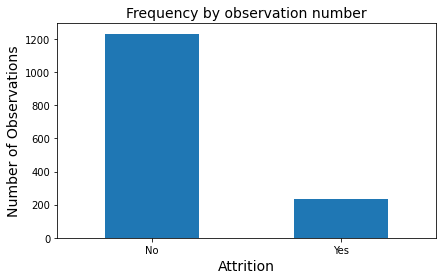

In [671]:
count_attrion = pd.value_counts(employee["Attrition"], sort = True)
count_attrion.plot(kind = 'bar', rot=0)
plt.title("Frequency by observation number")
plt.xlabel("Attrition") #deserción laboral
save_fig("attrition_unbalanced")  # extra code
plt.ylabel("Number of Observations");

In [672]:
(1233 - 237) / 1233

0.8077858880778589

En el set de datos se observa muy pocos datos donde se registre la deserción laboral.

In [673]:
normal_df = employee[employee.Attrition == 'Yes'] # guardar las observaciones de normal_df en un df separado
attrition_df = employee[employee.Attrition == 'No']  # hacer lo mismo con las deserciones laborales

* Análisis comparativo normalizado entre las variables del dataset y su relación con la deserción laboral

En las pruebas se encuentra que se tiene ninguna relación directa entre la deserción laboral y las siguientes variables:<br>
- Age, BusinessTravel, Department, DistanceFromHome, EducationField, Gender, HourlyRate, JobRole, MaritalStatus, OverTime, PercentSalaryHike, TotalWorkingYears, YearsAtCompany, YearsInCurrentRole, YearsWithCurrManager

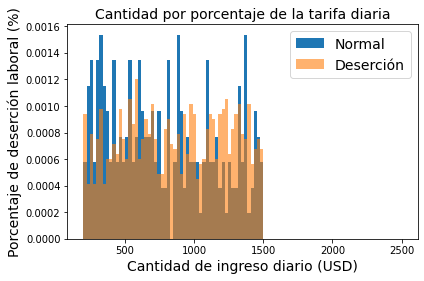

In [674]:
#DailyRate
bins = np.linspace(200, 2500, 100)
plt.hist(normal_df["DailyRate"], bins, alpha=1, density=True, label='Normal')
plt.hist(attrition_df["DailyRate"], bins, alpha=0.6, density=True, label='Deserción')
plt.legend(loc='upper right')
plt.title("Cantidad por porcentaje de la tarifa diaria")
plt.xlabel("Cantidad de ingreso diario (USD)")
plt.ylabel("Porcentaje de deserción laboral (%)");
save_fig("dailyrate_attrion")  # extra code
plt.show()

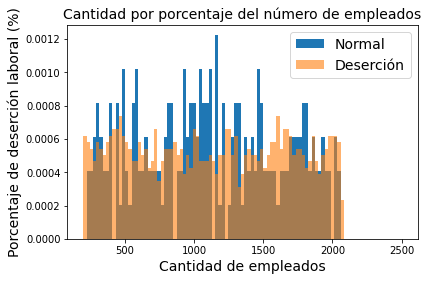

In [675]:
#EmployeeNumber
bins = np.linspace(200, 2500, 100)
plt.hist(normal_df["EmployeeNumber"], bins, alpha=1, density=True, label='Normal')
plt.hist(attrition_df["EmployeeNumber"], bins, alpha=0.6, density=True, label='Deserción')
plt.legend(loc='upper right')
plt.title("Cantidad por porcentaje del número de empleados")
plt.xlabel("Cantidad de empleados")
plt.ylabel("Porcentaje de deserción laboral (%)");
save_fig("employeenumber_attrion")  # extra code
plt.show()

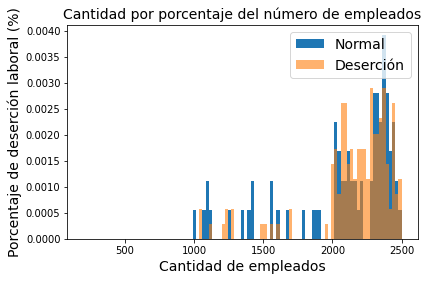

In [676]:
#MonthlyIncome
bins = np.linspace(200, 2500, 100)
plt.hist(normal_df["MonthlyIncome"], bins, alpha=1, density=True, label='Normal')
plt.hist(attrition_df["MonthlyIncome"], bins, alpha=0.6, density=True, label='Deserción')
plt.legend(loc='upper right')
plt.title("Cantidad por porcentaje del número de empleados")
plt.xlabel("Cantidad de empleados")
plt.ylabel("Porcentaje de deserción laboral (%)");
save_fig("monthlyincome_attrion")  # extra code
plt.show()

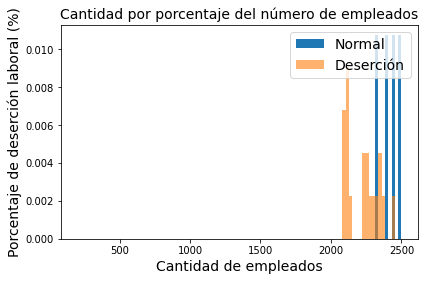

In [677]:
#MonthlyRate
bins = np.linspace(200, 2500, 100)
plt.hist(normal_df["MonthlyRate"], bins, alpha=1, density=True, label='Normal')
plt.hist(attrition_df["MonthlyRate"], bins, alpha=0.6, density=True, label='Deserción')
plt.legend(loc='upper right')
plt.title("Cantidad por porcentaje del número de empleados")
plt.xlabel("Cantidad de empleados")
plt.ylabel("Porcentaje de deserción laboral (%)");
save_fig("monthlyrate_attrion")  # extra code
plt.show()

Se realiza la visualización de la proporción de datos para cada variable categórica

Travel_Rarely        1043
Travel_Frequently     277
Non-Travel            150
Name: BusinessTravel, dtype: int64

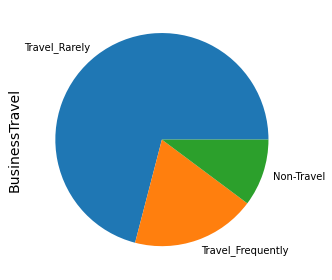

In [678]:
employee["BusinessTravel"].value_counts().plot(kind='pie')
save_fig("BusinessTravel_count")  # extra code
employee["BusinessTravel"].value_counts()

* "BusinessTravel" se clasifica como una variable Categórica - Nominal

Research & Development    961
Sales                     446
Human Resources            63
Name: Department, dtype: int64

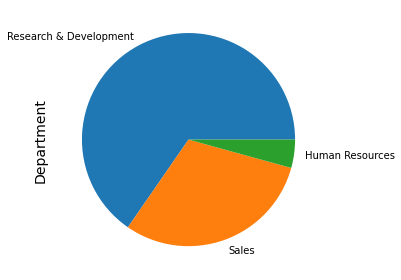

In [679]:
employee["Department"].value_counts().plot(kind='pie')
save_fig("Department_count")  # extra code
employee["Department"].value_counts()

* "Department" se clasifica como una variable Categórica - Nominal

Life Sciences       606
Medical             464
Marketing           159
Technical Degree    132
Other                82
Human Resources      27
Name: EducationField, dtype: int64

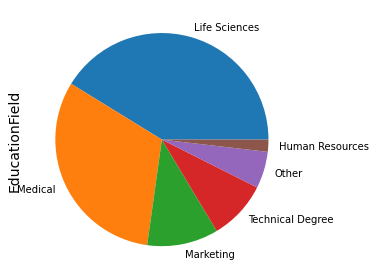

In [680]:
employee["EducationField"].value_counts().plot(kind='pie')
save_fig("EducationField_count")  # extra code
employee["EducationField"].value_counts()

* "EducationField" se clasifica como una variable Categórica - Nominal

Male      882
Female    588
Name: Gender, dtype: int64

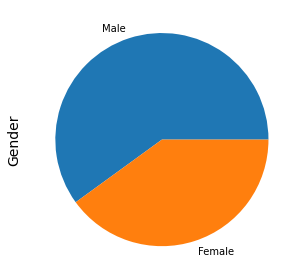

In [681]:
employee["Gender"].value_counts().plot(kind='pie')
save_fig("Gender_count")  # extra code
employee["Gender"].value_counts()

* "Gender" se clasifica como una variable Categórica - Nominal

Sales Executive              326
Research Scientist           292
Laboratory Technician        259
Manufacturing Director       145
Healthcare Representative    131
Manager                      102
Sales Representative          83
Research Director             80
Human Resources               52
Name: JobRole, dtype: int64

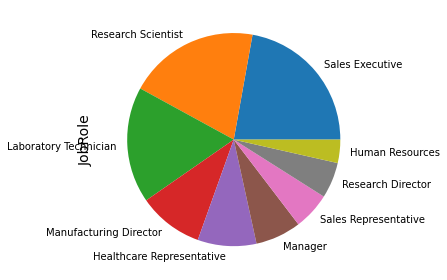

In [682]:
employee["JobRole"].value_counts().plot(kind='pie')
save_fig("JobRole_count")  # extra code
employee["JobRole"].value_counts()

"JobRole" se clasifica como una variable Categórica - Nominal

Married     673
Single      470
Divorced    327
Name: MaritalStatus, dtype: int64

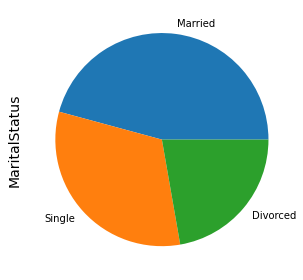

In [683]:
employee["MaritalStatus"].value_counts().plot(kind='pie')
save_fig("MaritalStatus_count")  # extra code
employee["MaritalStatus"].value_counts()

* "MaritalStatus" se clasifica como una variable Categórica - Nominal

No     1054
Yes     416
Name: OverTime, dtype: int64

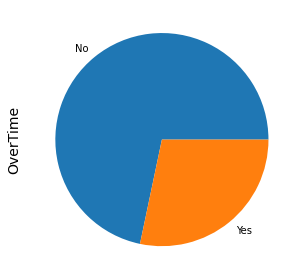

In [684]:
employee["OverTime"].value_counts().plot(kind='pie')
save_fig("OverTime_count")  # extra code
employee["OverTime"].value_counts()

* "OverTime" se clasifica como una variable Categórica - Binaria



In [685]:
employee["Over18"].value_counts()

Y    1470
Name: Over18, dtype: int64

* "Over18" se clasifica como una variable Categórica - Binaria.<br>

* De acuerdo con la clasificación, la variable "**Over18**" no es relevante ya que no presenta variación en alguna de las instacias del conjunto de datos.

Resumen de los atributos numéricos:

In [686]:
employee.describe()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,...,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,1.0,1024.865306,2.721769,65.891156,2.729932,2.063946,...,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,1.024165,0.0,602.024335,1.093082,20.329428,0.711561,1.106940,...,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,...,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,1.0,491.250000,2.000000,48.000000,2.000000,1.000000,...,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,3.000000,1.0,1020.500000,3.000000,66.000000,3.000000,2.000000,...,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,1.0,1555.750000,4.000000,83.750000,3.000000,3.000000,...,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,...,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


In [687]:
employee.nunique().sort_values()

Over18                         1
StandardHours                  1
EmployeeCount                  1
Gender                         2
Attrition                      2
PerformanceRating              2
OverTime                       2
MaritalStatus                  3
Department                     3
BusinessTravel                 3
StockOptionLevel               4
EnvironmentSatisfaction        4
JobInvolvement                 4
JobSatisfaction                4
RelationshipSatisfaction       4
WorkLifeBalance                4
Education                      5
JobLevel                       5
EducationField                 6
TrainingTimesLastYear          7
JobRole                        9
NumCompaniesWorked            10
PercentSalaryHike             15
YearsSinceLastPromotion       16
YearsWithCurrManager          18
YearsInCurrentRole            19
DistanceFromHome              29
YearsAtCompany                37
TotalWorkingYears             40
Age                           43
HourlyRate

In [688]:
employee = employee.drop(columns=['Over18'])
employee = employee.drop(columns=['StandardHours'])
employee = employee.drop(columns=['EmployeeCount'])
employee = employee.drop(columns=['EmployeeNumber'])

In [689]:
duplicate = employee[employee.duplicated()]
duplicate

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager


Entender la distribución de los datos:

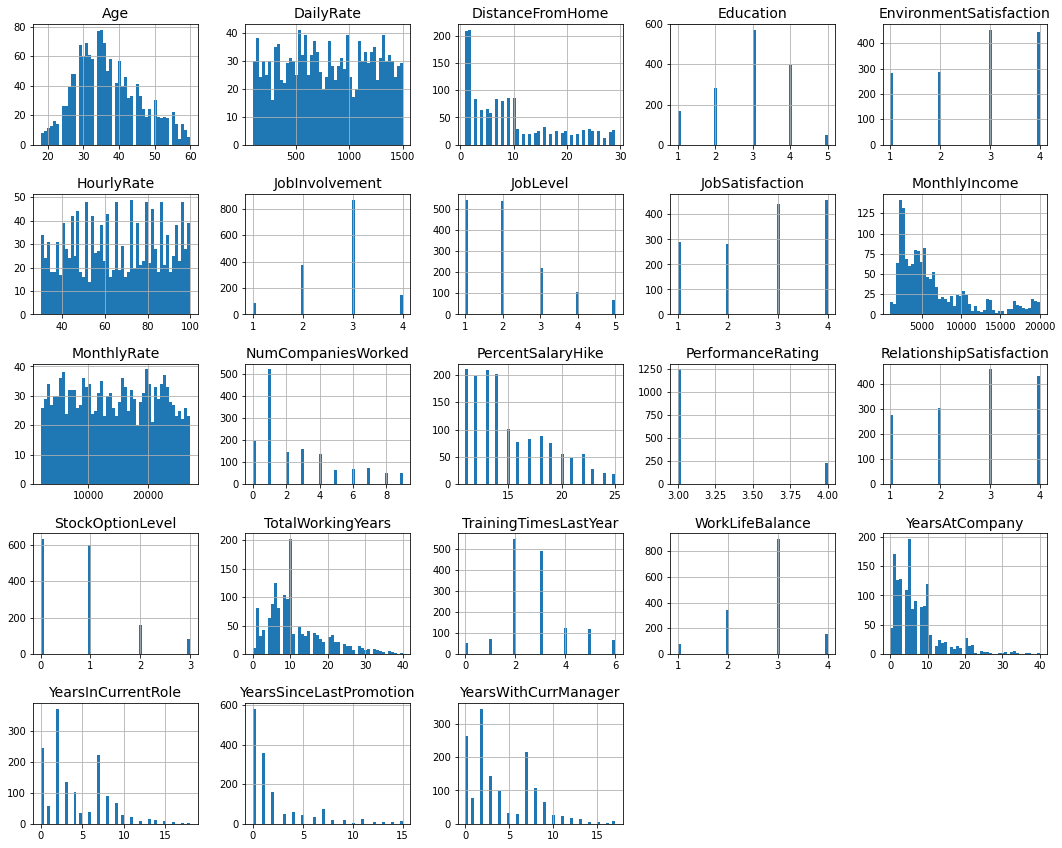

In [690]:
import matplotlib.pyplot as plt

# código extra - las siguientes 5 líneas definen los tamaños de fuente por defecto
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

employee.hist(bins=50, figsize=(15, 12))
save_fig("attribute_histogram_plots")  # extra code
plt.show()

In [691]:
employee.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EnvironmentSatisfaction   1470 non-null   int64 
 9   Gender                    1470 non-null   object
 10  HourlyRate                1470 non-null   int64 
 11  JobInvolvement            1470 non-null   int64 
 12  JobLevel                  1470 non-null   int64 
 13  JobRole                   1470 non-null   object
 14  JobSatisfaction         

In [692]:
#Transformación de las variables
for column in employee.columns:
  if employee[column].dtype == np.number:
    continue
  employee[column] = LabelEncoder().fit_transform(employee[column])

<ipython-input-692-274f91f767b0>:3: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if employee[column].dtype == np.number:


In [693]:
X = employee.drop(columns=['Attrition'])
y = employee['Attrition']

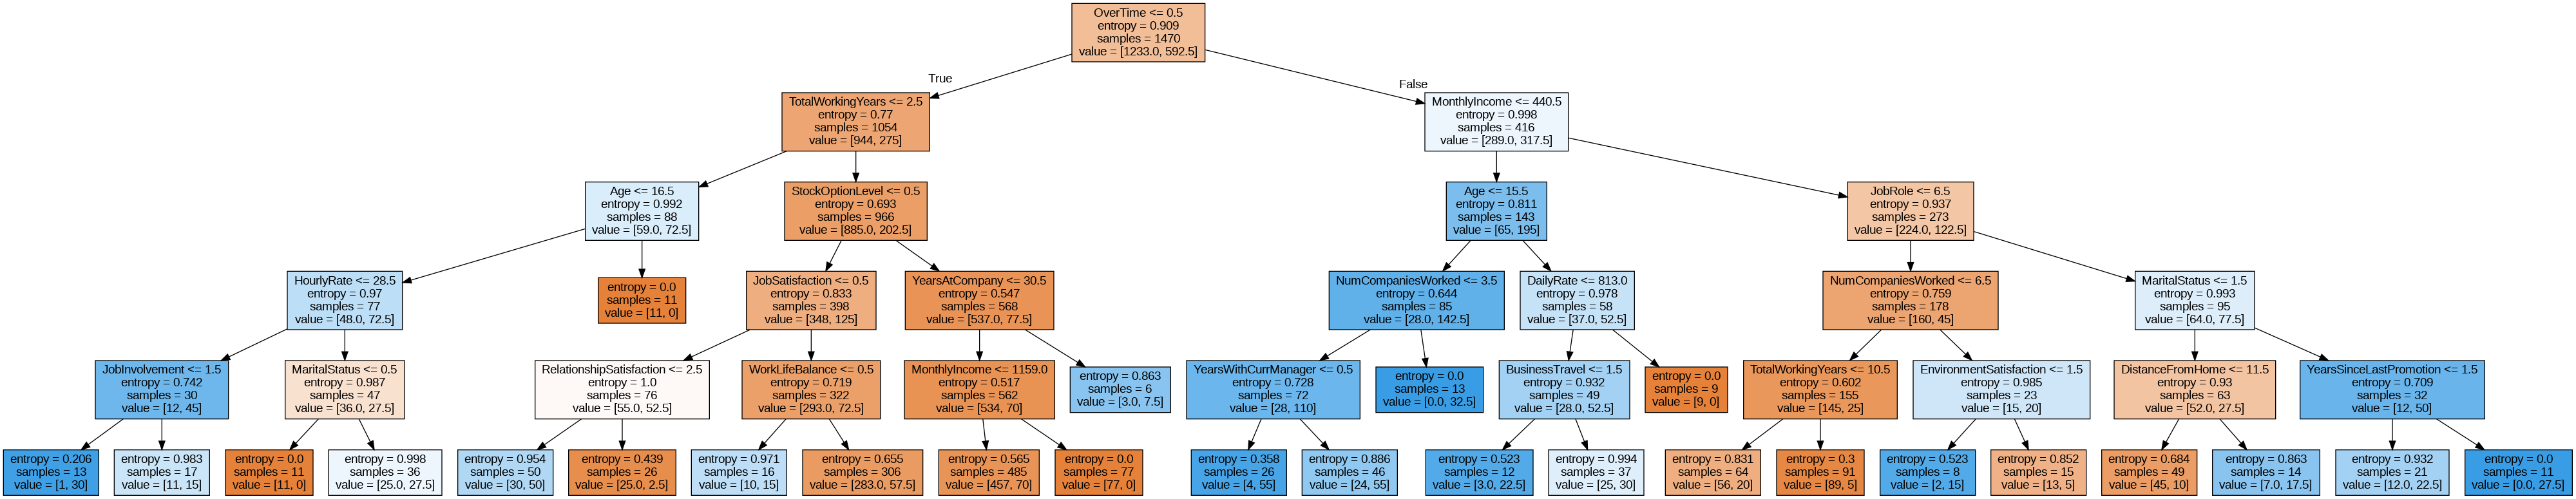

In [694]:
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
from subprocess import check_call
from IPython.display import Image as PImage
%matplotlib inline 

# Crear Arbol de decision con profundidad = 5  
decision_tree = tree.DecisionTreeClassifier(criterion='entropy',
                                            min_samples_split=20,
                                            min_samples_leaf=5,
                                            max_depth = 5,
                                            class_weight={1:2.5})

decision_tree.fit(X, y)
                  
# exportar el modelo a archivo .dot
with open(r"/content/images/end_to_end_project/arbol_decision.dot", 'w') as f:
  f = open("/content/images/end_to_end_project/arbol_decision.dot", 'w')
  tree.export_graphviz(decision_tree, out_file = f, feature_names = X.columns, filled=True)
  f.close()
  
 # Convertir el archivo .dot a png para poder visualizarlo
check_call(['dot','-Tpng',r'/content/images/end_to_end_project/arbol_decision.dot','-o',r'/content/images/end_to_end_project/arbol_decision.png'])
PImage("/content/images/end_to_end_project/arbol_decision.png")

Esta es una visión general de la correlación que existe entre las variables a evaluar y la variable objetivo. Partiendo por el valor mínimo de entropía en los nodos se puede determinar que la rama con variables 43, 16, 6 poseen la mejor alternativa a evaluar para enncontrar los factores de mayor peso en la deserción laboral.

## Crear un conjunto de pruebas (Test Set)

Se crea el conjunto de datos de entrenamiento del 80% de los datos y el conjunto de datos de pruebas con el 20% estratificado por la variable de objetivo para conservar el comportamiento de cada conjunto de datos respecto al conjunto de datos original:

In [695]:
from sklearn.model_selection import train_test_split #Divisor de los datos de entrenamiento 

strat_train_set, strat_test_set = train_test_split(employee, test_size=0.2, stratify=employee["Attrition"], random_state=20) #random_state -> semilla

Se categorizan las variables de tipo numérico:

In [696]:
numerical_columns = strat_train_set.drop(columns=['Attrition']).select_dtypes(include=np.number).columns
numerical_columns

Index(['Age', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome',
       'Education', 'EducationField', 'EnvironmentSatisfaction', 'Gender',
       'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobRole',
       'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome', 'MonthlyRate',
       'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike',
       'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

Se categorizan las variables categóricas

In [697]:
categorical_columns = strat_train_set.drop(columns=['Attrition']).select_dtypes(exclude=np.number).columns
categorical_columns

Index([], dtype='object')

Se construye pipeline para los datos numéricos:

In [698]:
numeric_transformer = Pipeline(
    steps=[("numerical_imputer", SimpleImputer(strategy='mean')), 
           ("scaler", StandardScaler())])

Se construye pipeline para los datos categóricos:

In [699]:
categorical_transformer = Pipeline(
    steps=[("label_encoder",  LabelEncoder())])

Se combina pipelines

In [700]:
preprocessor = ColumnTransformer(
    transformers=[
        ("numerical", numeric_transformer, numerical_columns),
        ("categorical", categorical_transformer, categorical_columns),
    ]
)

In [701]:
processed_train = preprocessor.fit_transform(strat_train_set)
pd.DataFrame(processed_train).head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,-0.866280,0.580062,1.504728,1.397375,0.083196,0.094489,-0.938161,0.261854,0.821714,1.616819,...,-0.419524,0.252007,-0.925806,-1.322485,2.501991,0.336336,-0.995488,-1.174508,-0.664657,-1.162827
1,0.312823,-0.932472,-0.508140,-0.493664,-0.040026,1.077847,0.573178,-0.651915,-1.216969,1.078698,...,-0.419524,0.252007,-0.925806,1.110782,0.165563,-1.076276,1.810348,0.766578,-0.052089,2.479315
2,-0.759089,-0.932472,1.255591,-0.493664,-0.902579,1.077847,2.084516,1.175623,-1.216969,0.589496,...,-0.419524,1.183957,-0.925806,-0.169884,-0.613246,0.336336,0.324906,0.766578,-0.664657,0.798327
3,0.527206,0.580062,0.326271,-0.493664,2.424410,0.094489,-0.938161,-0.651915,0.821714,1.567899,...,-0.419524,1.183957,0.277230,-0.169884,0.165563,-1.076276,0.324906,1.043876,1.479331,1.078491
4,-0.973472,-2.445006,1.706411,-0.493664,-1.025801,0.094489,-0.938161,0.261854,-1.216969,-0.535667,...,-0.419524,-1.611893,2.683302,-0.169884,2.501991,0.336336,0.324906,1.043876,1.479331,0.237997


In [702]:
X_train = pd.DataFrame(processed_train)
y_train = strat_train_set['Attrition']

## Descubrir y visualizar los datos para obtener información (insights)

Calcular el coeficiente de correlación estándar:

In [593]:
corr_matrix = employee.corr()
corr_matrix

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
Age,1.000000,0.010661,-0.001686,0.208034,0.010146,0.024287,0.029820,0.509604,-0.004892,0.497855,...,0.001904,0.053535,0.037510,0.680381,-0.019621,-0.021490,0.311309,0.212901,0.216513,0.202089
DailyRate,0.010661,1.000000,-0.004985,-0.016806,0.018355,0.023381,0.046135,0.002966,0.030571,0.007707,...,0.000473,0.007846,0.042143,0.014515,0.002453,-0.037848,-0.034055,0.009932,-0.033229,-0.026363
DistanceFromHome,-0.001686,-0.004985,1.000000,0.021042,-0.016075,0.031131,0.008783,0.005303,-0.003669,-0.017014,...,0.027110,0.006557,0.044872,0.004628,-0.036942,-0.026556,0.009508,0.018845,0.010029,0.014406
Education,0.208034,-0.016806,0.021042,1.000000,-0.027128,0.016775,0.042438,0.101589,-0.011296,0.094961,...,-0.024539,-0.009118,0.018422,0.148280,-0.025100,0.009819,0.069114,0.060236,0.054254,0.069065
EnvironmentSatisfaction,0.010146,0.018355,-0.016075,-0.027128,1.000000,-0.049857,-0.008278,0.001212,-0.006784,-0.006259,...,-0.029548,0.007665,0.003432,-0.002693,-0.019359,0.027627,0.001458,0.018007,0.016194,-0.004999
HourlyRate,0.024287,0.023381,0.031131,0.016775,-0.049857,1.000000,0.042861,-0.027853,-0.071335,-0.015794,...,-0.002172,0.001330,0.050263,-0.002334,-0.008548,-0.004607,-0.019582,-0.024106,-0.026716,-0.020123
JobInvolvement,0.029820,0.046135,0.008783,0.042438,-0.008278,0.042861,1.000000,-0.012630,-0.021476,-0.015271,...,-0.029071,0.034297,0.021523,-0.005533,-0.015338,-0.014617,-0.021355,0.008717,-0.024184,0.025976
JobLevel,0.509604,0.002966,0.005303,0.101589,0.001212,-0.027853,-0.012630,1.000000,-0.001944,0.950300,...,-0.021222,0.021642,0.013984,0.782208,-0.018191,0.037818,0.534739,0.389447,0.353885,0.375281
JobSatisfaction,-0.004892,0.030571,-0.003669,-0.011296,-0.006784,-0.071335,-0.021476,-0.001944,1.000000,-0.007157,...,0.002297,-0.012454,0.010690,-0.020185,-0.005779,-0.019459,-0.003803,-0.002305,-0.018214,-0.027656
MonthlyIncome,0.497855,0.007707,-0.017014,0.094961,-0.006259,-0.015794,-0.015271,0.950300,-0.007157,1.000000,...,-0.017120,0.025873,0.005408,0.772893,-0.021736,0.030683,0.514285,0.363818,0.344978,0.344079


<AxesSubplot:>

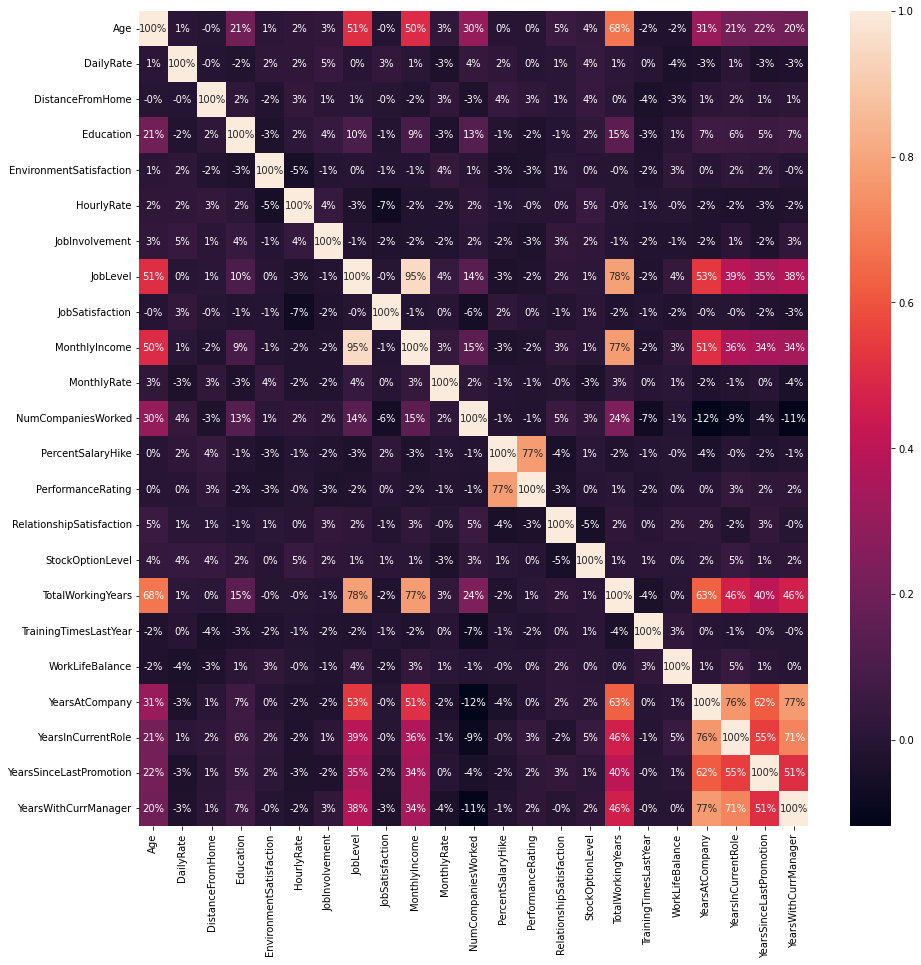

In [600]:
plt.figure(figsize=(15,15))
save_fig("matriz_correlacion")  # extra code
sns.heatmap(corr_matrix, annot=True, fmt='.0%')

Correlación de los datos con la variable "Age"

In [602]:
corr_matrix["YearsWithCurrManager"].sort_values(ascending=False)

YearsWithCurrManager        1.000000
YearsAtCompany              0.769212
YearsInCurrentRole          0.714365
YearsSinceLastPromotion     0.510224
TotalWorkingYears           0.459188
JobLevel                    0.375281
MonthlyIncome               0.344079
Age                         0.202089
Education                   0.069065
JobInvolvement              0.025976
StockOptionLevel            0.024698
PerformanceRating           0.022827
DistanceFromHome            0.014406
WorkLifeBalance             0.002759
RelationshipSatisfaction   -0.000867
TrainingTimesLastYear      -0.004096
EnvironmentSatisfaction    -0.004999
PercentSalaryHike          -0.011985
HourlyRate                 -0.020123
DailyRate                  -0.026363
JobSatisfaction            -0.027656
MonthlyRate                -0.036746
NumCompaniesWorked         -0.110319
Name: YearsWithCurrManager, dtype: float64